In [136]:
import os 
import torch
import torch.nn as nn
import torchvision.transforms as tf 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
%matplotlib inline

data_dirc="C:/Users/gjq/OneDrive/桌面/test/data2/"


In [137]:
print(torch.__version__)


1.8.0


In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [139]:
workers=2
batch_size=128
image_size=64
ms=((0.5,0.5,0.5),(0.5,0.5,0.5))

In [140]:
dataset = ImageFolder(data_dirc,
                           transform=tf.Compose([
                               tf.Resize(image_size),
                               tf.CenterCrop(image_size),
                               tf.ToTensor(),
                               tf.Normalize(*ms),
                           ]))
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [141]:
len(dataset)

4559

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])

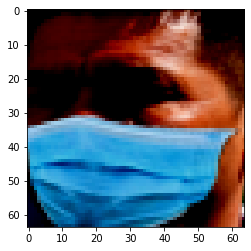

In [142]:
image,_ = dataset[0]
plt.imshow(image.permute(1,2,0))
image.size()

In [143]:
def denormalized(img):
    return img * ms[1][0] + ms[0][0]

torch.Size([128, 3, 64, 64])


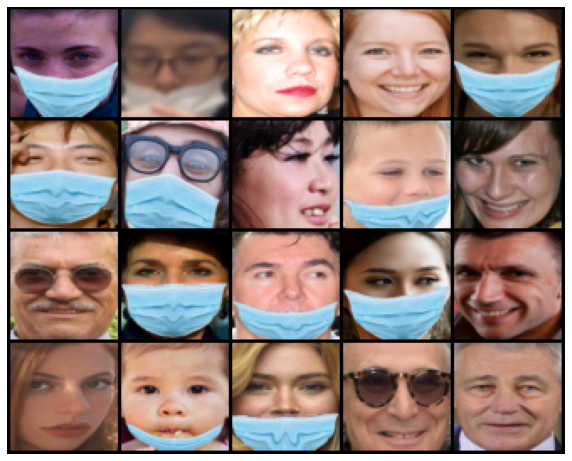

In [144]:
image,_ = next(iter(dataloader))
print(image.shape)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(make_grid(denormalized(image)[:20],nrow=5).permute(1,2,0))

In [145]:
def deviceLoaderfunc(data,device):
    if isinstance(data,(list,tuple)):
        return [deviceLoaderfunc(x, device) for x in data]
    return data.to(device, non_blocking=True)


In [146]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield deviceLoaderfunc(b, self.device)
            
    def __len__(self):
        return len(self.dl)


In [147]:
dataloader = DeviceDataLoader(dataloader, device)

In [148]:
latent_size = 128

In [149]:
discriminator = nn.Sequential(
    # 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()) # we generally use sigmoid function at the end of all network to finally 
                # get the bounded result



In [150]:
discriminator = deviceLoaderfunc(discriminator, device)
# discriminator.load_state_dict(torch.load("dis2.pkl"))

In [151]:
generator = nn.Sequential(
    # 128 x 1 x 1  here 128 is the latent size

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    # 512 x 4 x 4 upsampled data

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    # 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    # 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # 3 x 64 x 64
)   

In [152]:
generator = deviceLoaderfunc(generator, device)
generator.load_state_dict(torch.load("gen_final_transfer.pkl"))

<All keys matched successfully>

In [153]:
def train_discriminator(r_images,optimizer):
    
    optimizer.zero_grad()
    # prediction
    # setting the target for prediction
    # calculating loss
    # getting score
    r_preds=discriminator(r_images)
    r_targets=torch.ones(r_images.size(0),1,device=device)# our target is to get result one for real images
    r_loss = F.binary_cross_entropy(r_preds, r_targets) # used for yes or no , fake or not fake type data
    r_score = torch.mean(r_preds).item()

    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    g_images = generator(latent) # generating fake images
    
    # Pass fake images through discriminator
    g_targets = torch.zeros(g_images.size(0), 1, device=device)
    g_preds = discriminator(g_images)
    g_loss = F.binary_cross_entropy(g_preds, g_targets)
    g_score = torch.mean(g_preds).item()

    # Updating discriminator weights
    loss = r_loss + g_loss
    loss.backward()
    optimizer.step()
    return loss.item(), r_score,g_score

In [154]:
def train_generator(optimizer):
    
    optimizer.zero_grad()
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    g_images = generator(latent)
    
    preds = discriminator(g_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [155]:
latent_noise = torch.randn(64, latent_size, 1, 1, device=device)
os.makedirs('new_gen_img', exist_ok=True)
def fit(epochs, lr, index=1):
    
    torch.cuda.empty_cache()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    # and epochs
    
    for epoch in range(epochs):
        lr=lr*0.995
        d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
        for r_images, _ in tqdm(dataloader):
            loss_d, r_score, g_score = train_discriminator(r_images, d_optimizer)
            loss_g = train_generator(g_optimizer)
            loss_g = train_generator(g_optimizer)
        
        # saving images with save_image module of torchvision
        g_images=generator(latent_noise)
        if epoch%5==0:
            fimg_name='images-{0:0=4d}.png'.format(epoch+index,)
            save_image(denormalized(g_images),os.path.join('new_gen_img',fimg_name),nrow=8)
            
            print(" {} out of {} epochs, loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, epochs, loss_g, loss_d, r_score, g_score))

if os.path.exists("gen.pkl") and os.path.exists("dis.pkl"):
  generator.load_state_dict=torch.load('gen.pkl')
  discriminator.load_state_dict=torch.load('dis.pkl')
  print("exist file loaded")

In [156]:
records=fit(1,0.0002)


  0%|          | 0/36 [00:00<?, ?it/s]

 1 out of 1 epochs, loss_g: 0.8696, loss_d: 1.3813, real_score: 0.4778, fake_score: 0.4373


In [157]:
# torch.save(generator.state_dict(),'gen_final_transfer.pkl')
# torch.save(discriminator.state_dict(),'dis_final_transfer.pkl')

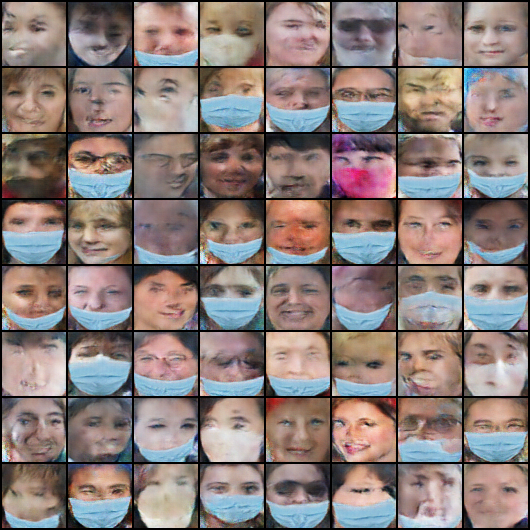

In [163]:
generator.load_state_dict(torch.load("gen_final_transfer.pkl"))
gen_image=generator(latent_noise)
fimg_name='images-gnereate.png'
save_image(denormalized(gen_image),os.path.join('new_gen_img',fimg_name),nrow=8)
Image.open('./new_gen_img/images-gnereate.png')